In [2]:
!pip install -q roboflow supervision

In [3]:
!pip list | grep supervision

supervision                              0.20.0


In [19]:
!conda env list


# conda environments:
#
                         /opt/conda/envs/new_env
base                  *  /opt/conda/envs/pytorch



In [4]:
from roboflow import Roboflow

ROBOFLOW_API_KEY = "eYGC8ynVGm79DguQ2Ynl"

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("srinithi-s-tzdkb").project("fracture-detection-rhud5")
version = project.version(4)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...


In [1]:
# Sample json format
sample = {"image":"n_0_2513_png_jpg.rf.1f679ff5dec5332cf06f6b9593c8437b.jpg","prefix":"detect fracture","suffix":"<loc0390><loc0241><loc0472><loc0440> fracture"}


In [2]:
# Read the vlm.jsonl
import os
import json

vlm_json_path = os.path.join("advanced", "vlm.jsonl")

# Check if file exists
try:
    with open(vlm_json_path, "r") as f:
        pass
except FileNotFoundError:
    print(f"File {vlm_json_path} not found")
    
vlm_data = []
with open(vlm_json_path, "r") as f:
    for line in f:
        data = json.loads(line)
        vlm_data.append(data)
        


In [3]:
import pprint
pprint.pprint(sample)
pprint.pprint(vlm_data[0])

{'image': 'n_0_2513_png_jpg.rf.1f679ff5dec5332cf06f6b9593c8437b.jpg',
 'prefix': 'detect fracture',
 'suffix': '<loc0390><loc0241><loc0472><loc0440> fracture'}
{'annotations': [{'bbox': [912, 164, 48, 152], 'caption': 'grey missile'},
                 {'bbox': [1032, 80, 24, 28],
                  'caption': 'red, white, and blue light aircraft'},
                 {'bbox': [704, 508, 76, 64],
                  'caption': 'green and black missile'},
                 {'bbox': [524, 116, 112, 48],
                  'caption': 'white and red helicopter'}],
 'image': 'image_0.jpg'}


In [4]:
import re
import numpy as np
import supervision as sv
from typing import Tuple, List, Optional


def from_pali_gemma(
    response: str,
    resolution_wh: Tuple[int, int],
    classes: Optional[List[str]] = None
) -> sv.Detections:
    _SEGMENT_DETECT_RE = re.compile(
        r'(.*?)' +
        r'<loc(\d{4})>' * 4 + r'\s*' +
        '(?:%s)?' % (r'<seg(\d{3})>' * 16) +
        r'\s*([^;<>]+)? ?(?:; )?',
    )
    
    width, height = resolution_wh
    xyxy_list = []
    class_name_list = []

    while response:
        m = _SEGMENT_DETECT_RE.match(response)
        if not m:
            break

        gs = list(m.groups())
        before = gs.pop(0)
        name = gs.pop()
        y1, x1, y2, x2 = [int(x) / 1024 for x in gs[:4]]
        y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

        content = m.group()
        if before:
            response = response[len(before):]
            content = content[len(before):]

        xyxy_list.append([x1, y1, x2, y2])
        class_name_list.append(name.strip())
        response = response[len(content):]

    
    xyxy = np.array(xyxy_list)
    class_name = np.array(class_name_list)

    if classes is None:
        class_id = None
    else:
        class_id = np.array([classes.index(name) for name in class_name])
        
    

    return sv.Detections(
        xyxy=xyxy,
        class_id=class_id,
        data={'class_name': class_name}
    )


# to_pali_gemma_xyxy
def to_pali_gemma_xyxy(
    xyxy: List[int],
    resolution_wh: Tuple[int, int],
    classes: str
) -> str:
    width, height = resolution_wh
    x1, y1, x2, y2 = xyxy
    y1, x1, y2, x2 = y1/height, x1/width, y2/height, x2/width
    y1, x1, y2, x2 = int(y1*1024), int(x1*1024), int(y2*1024), int(x2*1024)
    return f"<loc{y1:04d}><loc{x1:04d}><loc{y2:04d}><loc{x2:04d}> {classes}"

In [14]:
new_data = []

for data in vlm_data:
    image = data['image']
    image_new = os.path.join("advanced","images", image)
    annotations = data['annotations']
    for annotation in annotations:
        bbox = annotation['bbox']
        caption = annotation['caption']
        # Convert bbox coordinates into the specific string format
        # Assuming bbox = [x, y, width, height]
        x, y, w, h = bbox
        x1, y1, x2, y2 = x, y, x + w, y + h
        
        # Formatting each coordinate and dimension as four-digit locations
        loc_format = to_pali_gemma_xyxy([x1, y1, x2, y2], (1520, 870), caption)
        
        suffix = f"{loc_format}"
        
        # Prefix that mentions detecting the object described in the caption
        prefix = f"detect {caption}"
        
        # Create a structured dictionary for each annotation
        transformed_data = {
            'image': image_new,
            'prefix': prefix,
            'suffix': suffix
        }
        
        # Append the structured data to the new list
        new_data.append(transformed_data)
        
new_data[0]



{'image': 'advanced/images/image_0.jpg',
 'prefix': 'detect grey missile',
 'suffix': '<loc0193><loc0614><loc0371><loc0646> grey missile'}

In [16]:
# Save the new_data 
new_vlm_json_path = os.path.join("new_vlm.jsonl")

# If it already exists, delete it
if os.path.exists(new_vlm_json_path):
    os.remove(new_vlm_json_path)

with open(new_vlm_json_path, "w") as f:
    for data in new_data:
        f.write(json.dumps(data) + "\n")


In [5]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"n_0_2513_png_jpg.rf.1f679ff5dec5332cf06f6b9593c8437b.jpg","prefix":"detect fracture","suffix":"<loc0390><loc0241><loc0472><loc0440> fracture"}
{"image":"z_0_6860_png_jpg.rf.202e44ec4d3df2c8505191325cbcc050.jpg","prefix":"detect fracture","suffix":"<loc0656><loc0724><loc0735><loc0814> fracture ; <loc0725><loc0812><loc0813><loc0914> fracture"}
{"image":"flip_0_1745_png_jpg.rf.1d780816e799cad51385a45f878667c6.jpg","prefix":"detect fracture","suffix":"<loc0181><loc0650><loc0576><loc0744> fracture"}
{"image":"all_0_6198_png_jpg.rf.23769e75c171aa5dc14fbca401dd4148.jpg","prefix":"detect fracture","suffix":"<loc0411><loc0712><loc0700><loc0993> fracture"}
{"image":"flip_0_9639_png_jpg.rf.20459394241e1694f9135591a777370a.jpg","prefix":"detect fracture","suffix":"<loc0637><loc0525><loc0708><loc0744> fracture"}


{'image': 'advanced/images/image_2.jpg', 'prefix': 'detect grey drone', 'suffix': '<loc0348><loc0371><loc0409><loc0409> grey drone'}
(1520, 870)
['grey drone']
(1520, 870)
<re.Match object; span=(0, 47), match='<loc0348><loc0371><loc0409><loc0409> grey drone'>
[[551, 296, 607, 347]]


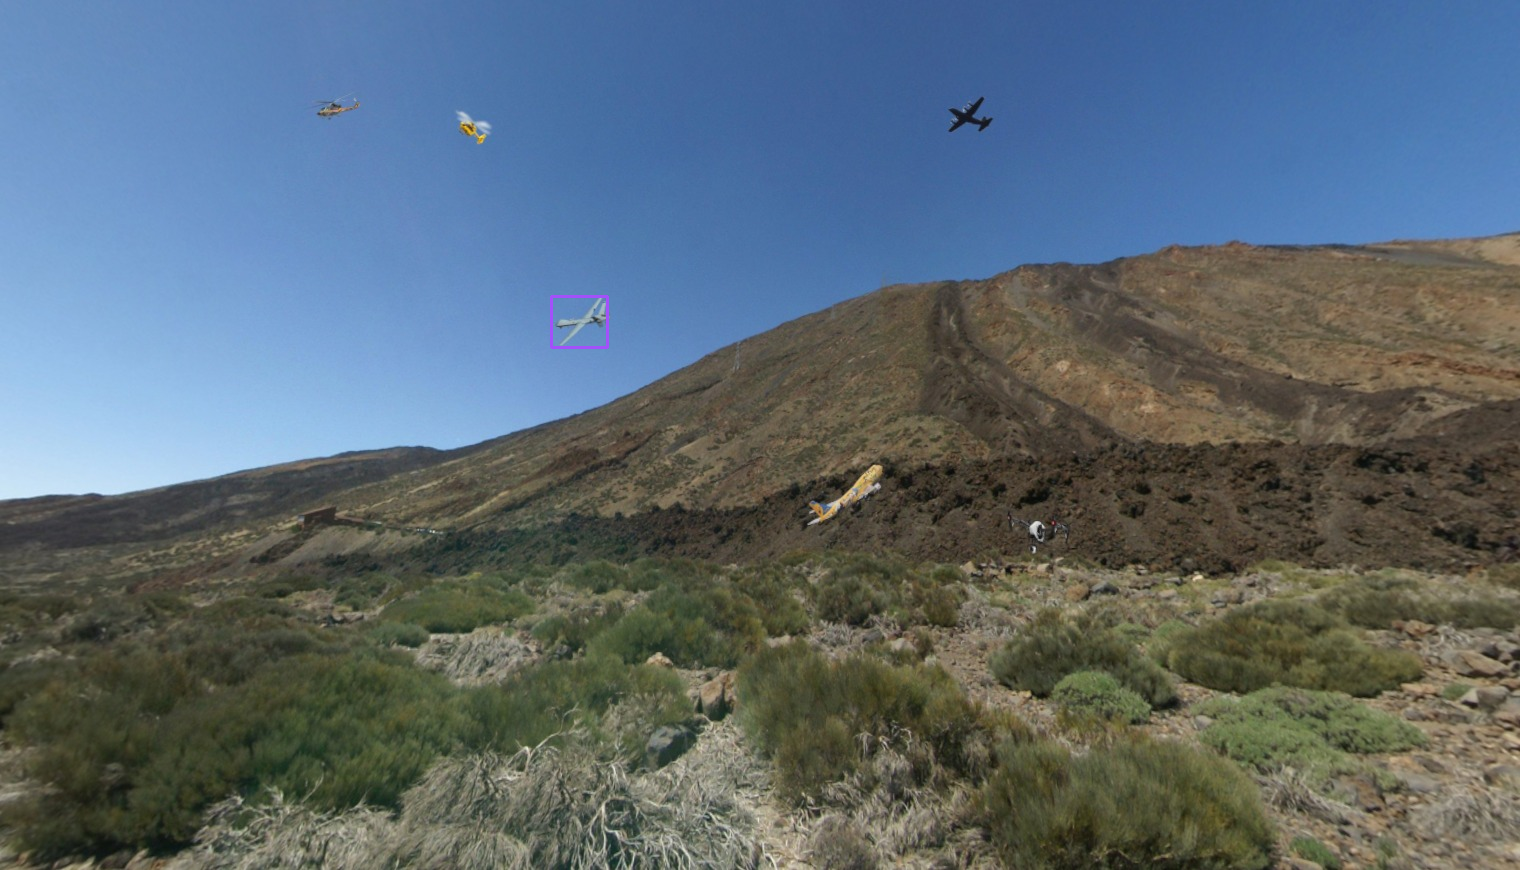

In [17]:
from PIL import Image
import json

index = 10

first = json.loads(open(new_vlm_json_path).readlines()[index])
print(first)

image = Image.open(first.get('image'))
print(image.size)
CLASSES = first.get('prefix').replace("detect ", "").split(" ; ")
print(CLASSES)
detections = from_pali_gemma(first.get('suffix'), image.size, CLASSES)

sv.BoundingBoxAnnotator().annotate(image, detections)

In [11]:
# Split the dataset into train and valid
from sklearn.model_selection import train_test_split
import random

# Read the new_vlm.jsonl
new_data = []
with open(new_vlm_json_path, "r") as f:
    for line in f:
        data = json.loads(line)
        new_data.append(data)

# Split the dataset into train and valid
train_data, valid_data = train_test_split(new_data, test_size=0.2, random_state=42)

# Save the train and valid data
train_vlm_json_path = os.path.join("train_vlm.jsonl")
valid_vlm_json_path = os.path.join("valid_vlm.jsonl")

# If it already exists, delete it
if os.path.exists(train_vlm_json_path):
    os.remove(train_vlm_json_path)

if os.path.exists(valid_vlm_json_path):
    os.remove(valid_vlm_json_path)

with open(train_vlm_json_path, "w") as f:
    for data in train_data:
        f.write(json.dumps(data) + "\n")

with open(valid_vlm_json_path, "w") as f:
    for data in valid_data:
        f.write(json.dumps(data) + "\n")


In [5]:
# Fetch big_vision code and install dependencies.

# @title Fetch big_vision code and install dependencies.
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


In [6]:
import os

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

os.environ["KAGGLE_USERNAME"] = "chengyixing"
os.environ["KAGGLE_KEY"] = "00d767313e048d3acf61bc3c1eabba3a"

In [24]:
!pip install kagglehub

In [8]:
# @title Download checkpoint, tokenizer and dataset to local filesystem.
#
import os
import kagglehub

MODEL_PATH = "./paligemma-3b-pt-224.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', MODEL_PATH)
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

Model path: /home/jupyter/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/./paligemma-3b-pt-224.f16.npz


In [7]:
MODEL_PATH_FINETUNED = "models/vlm/fine-tuned-test-paligemma-3b-pt-224.f16.npz"

In [ ]:
!pip install -U "jax[cuda12]"

In [25]:
!pip list | grep jax

jax                                      0.4.28
jax-cuda12-pjrt                          0.4.28
jax-cuda12-plugin                        0.4.28
jax-jumpy                                1.0.0
jaxlib                                   0.4.28
jupyter-server-mathjax                   0.2.6


In [21]:
!nvidia smi

/bin/bash: line 1: nvidia: command not found


In [ ]:
!pip install tensorflow

In [ ]:
!pip install flax

In [9]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

JAX version:  0.4.28
JAX platform: gpu
JAX devices:  1


In [10]:
# @title Construct model and load params into RAM.

# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
print("1")
model = paligemma.Model(**model_config)
print("2")
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)
print("3")

print("Initialising model")
# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH_FINETUNED, model_config)
print("Model finished initialising")

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

1
2
3
Initialising model
Model finished initialising


In [11]:
# @title Move params to GPU/TPU memory.
#
# To keep HBM usage low and fit in a T4 GPU (16GB HBM) we opt to only finetune
# a part of the parameters. Additionally we keep the frozen params in float16
# and cast trainable to float32.

# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

#
# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)



In [12]:
# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default (12GB RAM).
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

print(" == Model params == ")
parameter_overview(params)

 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/kernel                           (27, 1152, 4304)       float16
img/Transformer/encoderblock/MlpBlock_0/Dense_1/bias                             (2

In [13]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [14]:
# @title Function to iterate over train and validation examples.
SEQLEN = 128

# train_path = "train_vlm.jsonl"
train_path = "train_vlm.jsonl"
val_path = "valid_vlm.jsonl"

# TODO: Consider data iterators skipping big_vision and tf.data?
train_dataset = big_vision.datasets.jsonl.DataSource(
    train_path)

val_dataset = big_vision.datasets.jsonl.DataSource(
    val_path)

print(train_dataset)

def train_data_iterator():
  """Never ending iterator over training examples."""
  # Shuffle examples and repeat so one can train for many epochs.
  dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
  for example in dataset.as_numpy_iterator():
    image_path = example['image'].decode("utf-8")
    image = Image.open(image_path)
    # image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # prefix = "caption en"  # Could also be a different prefix per example.
    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_loss": np.asarray(mask_loss),
    }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image_path = example['image'].decode("utf-8")
    image = Image.open(image_path)
    # image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    # prefix = "caption en"  # Could also be a different prefix per example.
    prefix = example["prefix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }
    



In [15]:
# @title Inspect training examples.
def split_and_keep_second_part(s):
  parts = s.split('\n', 1)
  if len(parts) > 1:
    return parts[1]
  return s

def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption, classes):
    image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    h, w, _ = image.shape
    try:
        detections = from_pali_gemma(caption, (w, h), classes)
        print(f"Detections: {detections}")
        image = sv.BoundingBoxAnnotator().annotate(image, detections)
    except Exception as e:
        print(f"Error is {e}")
        print("result render failed, result:", caption)
    return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(128,128))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

# html_out = ""
# for idx, example in zip(range(3), train_data_iterator()):
#     caption = postprocess_tokens(example["text"])  # detokenize model input.
#     classess = caption.replace('detect ', '')
#     caption = split_and_keep_second_part(caption)
#     print(classess)
#     html_out += render_example(example["image"], caption, classess)

# print("Training examples")
# display(HTML(html_out))

In [16]:
# @title Define the training step and evaluation loop.
#
# The main update_fn using simple SGD.
#
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
    imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

    def loss_fn(params):
        text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
        logp = jax.nn.log_softmax(text_logits, axis=-1)

        # The model takes as input txts[:, :-1] but the loss is defined as predicting
        # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
        # are part of the loss (e.g. prefix and padded tokens are not included).
        mask_loss = batch["mask_loss"][:, 1:]
        targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

        # Compute the loss per example. i.e. the mean of per token pplx.
        # Since each example has a different number of tokens we normalize it.
        token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
        example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
        example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

        # batch_loss: mean of per example loss.
        return jnp.mean(example_loss)

    loss, grads = jax.value_and_grad(loss_fn)(params)

      # Apply gradients to trainable params using SGD.
    def apply_grad(param, gradient, trainable):
        if not trainable: return param
        return param - learning_rate * gradient

    params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

    return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = big_vision.utils.reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode({"params": params}, batch=batch,
                        max_decode_len=seqlen, sampler=sampler)

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        responses = [postprocess_tokens(t) for t in tokens]
        print(f"Responses = {responses})")

        # Append to html output.
        for example, response in zip(examples, responses):
            outputs.append((example, response))
            if num_examples and len(outputs) >= num_examples:
                return outputs

Model predictions
Responses = ['<loc0204><loc0344><loc0244><loc0373> grey and white fighter plane'])
(224, 224)
<re.Match object; span=(0, 65), match='<loc0204><loc0344><loc0244><loc0373> grey and whi>
[[75, 45, 82, 53]]
Detections: Detections(xyxy=array([[75, 45, 82, 53]]), mask=None, confidence=None, class_id=array([37]), tracker_id=None, data={'class_name': array(['grey and white fighter plane'], dtype='<U28')})



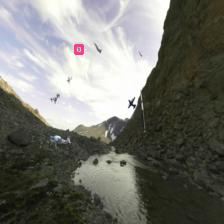

In [21]:
# @title Let't check model performance without finetuning

print("Model predictions")
html_out = ""
for example, caption in make_predictions(validation_data_iterator(), num_examples=1, batch_size=1):
    response = postprocess_tokens(example["text"])  # detokenize model input.
    classes = caption.replace('detect ', '')
    label = split_and_keep_second_part(response)
    html_out += render_example(example["image"], caption, classes)
display(HTML(html_out))


In [ ]:
# @title Run training loop.
#
# Run a short training loop with cosine learning rate schedule.
#
# Note: the first step can be quite slow on some machines (up to several minutes)
# due to XLA compilation of the jax.jit'd function.
#
import time

start_time = time.time()

BATCH_SIZE = 8
TRAIN_EXAMPLES = 2048
# TRAIN_EXAMPLES = 256
LEARNING_RATE = 0.01

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
    decay_type="cosine", warmup_percent=0.10)

for step in range(1, TRAIN_STEPS+1):
  # Make list of N training examples.
    examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

  # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

  # Training step and report training loss
    learning_rate = sched_fn(step)
    params, loss = update_fn(params, batch, learning_rate)
    
    loss = jax.device_get(loss)
    print(f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

    if step == 1 or (step % EVAL_STEPS) == 0:
        print(f"Model predictions at step {step}")
        html_out = ""
        for example, caption in make_predictions(
            validation_data_iterator(), num_examples=4, batch_size=4):
            response = postprocess_tokens(example["text"])  # detokenize model input.
            classes = caption.replace('detect ', '')
            label = split_and_keep_second_part(response)
            html_out += render_example(example["image"], caption, classes)
        display(HTML(html_out))
        
end_time = time.time()

print("End time: ", end_time)


In [ ]:
train_data_it = train_data_iterator()

counter = 0

for x in train_data_it:
    counter += 1
    
counter

TypeError: object of type 'generator' has no len()

Starting epoch 1/1


2024-05-23 12:58:13.536569: W external/xla/xla/service/hlo_rematerialization.cc:2948] Can't reduce memory use below 4.90GiB (5263482524 bytes) by rematerialization; only reduced to 10.12GiB (10862416592 bytes), down from 10.12GiB (10862425840 bytes) originally


step: 1   lr: 0.00004   loss: 1.6250
Model predictions at step 1
Responses = ['<loc0204><loc0344><loc0244><loc0373> grey and white fighter plane', '<loc0161><loc0795><loc0216><loc0835> white and orange commercial aircraft', '<loc0100><loc0658><loc0141><loc0684> grey cargo aircraft', '<loc0253><loc0309><loc0293><loc0366> blue camouflage fighter jet'])
Detections: Detections(xyxy=array([[75, 45, 82, 53]]), mask=None, confidence=None, class_id=array([0]), tracker_id=None, data={'class_name': array(['grey and white fighter plane'], dtype='<U28')})
Detections: Detections(xyxy=array([[174,  35, 183,  47]]), mask=None, confidence=None, class_id=array([0]), tracker_id=None, data={'class_name': array(['white and orange commercial aircraft'], dtype='<U36')})
Detections: Detections(xyxy=array([[144,  22, 150,  31]]), mask=None, confidence=None, class_id=array([0]), tracker_id=None, data={'class_name': array(['grey cargo aircraft'], dtype='<U19')})
Detections: Detections(xyxy=array([[68, 55, 80, 6


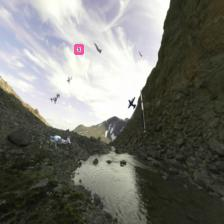
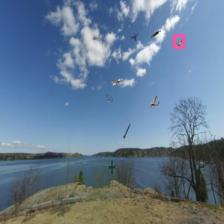
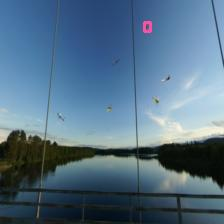
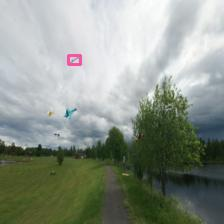

step: 2   lr: 0.00007   loss: 1.7807
step: 3   lr: 0.00011   loss: 1.8988
step: 4   lr: 0.00015   loss: 1.6661
step: 5   lr: 0.00018   loss: 1.6803
step: 6   lr: 0.00022   loss: 2.0052
step: 7   lr: 0.00025   loss: 1.6806
step: 8   lr: 0.00029   loss: 1.8137
step: 9   lr: 0.00033   loss: 1.9680
step: 10   lr: 0.00036   loss: 1.6615
step: 11   lr: 0.00040   loss: 1.5581
step: 12   lr: 0.00044   loss: 1.8972
step: 13   lr: 0.00047   loss: 1.9001
step: 14   lr: 0.00051   loss: 1.7410
step: 15   lr: 0.00055   loss: 2.2417
step: 16   lr: 0.00058   loss: 1.9265
step: 17   lr: 0.00062   loss: 1.5585
step: 18   lr: 0.00065   loss: 1.5593
step: 19   lr: 0.00069   loss: 1.5291
step: 20   lr: 0.00073   loss: 1.5785
step: 21   lr: 0.00076   loss: 1.6936
step: 22   lr: 0.00080   loss: 1.9860
step: 23   lr: 0.00084   loss: 1.6476
step: 24   lr: 0.00087   loss: 2.0283
step: 25   lr: 0.00091   loss: 1.6559
step: 26   lr: 0.00095   loss: 1.6615
step: 27   lr: 0.00098   loss: 1.8734
step: 28   lr: 0.001


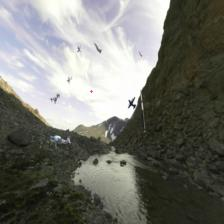
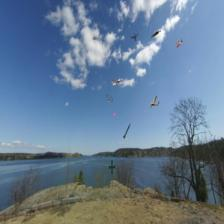
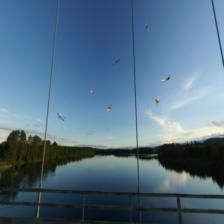
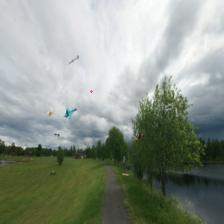

step: 344   lr: 0.00998   loss: 2.4160
step: 345   lr: 0.00998   loss: 2.8334
step: 346   lr: 0.00998   loss: 2.6244
step: 347   lr: 0.00998   loss: 2.7610
step: 348   lr: 0.00998   loss: 2.5789
step: 349   lr: 0.00998   loss: 2.8029
step: 350   lr: 0.00998   loss: 2.5759
step: 351   lr: 0.00998   loss: 2.4459
step: 352   lr: 0.00998   loss: 2.6404
step: 353   lr: 0.00998   loss: 2.7398
step: 354   lr: 0.00997   loss: 2.5116
step: 355   lr: 0.00997   loss: 2.6924
step: 356   lr: 0.00997   loss: 2.4914
step: 357   lr: 0.00997   loss: 2.5722
step: 358   lr: 0.00997   loss: 2.3726
step: 359   lr: 0.00997   loss: 2.4576
step: 360   lr: 0.00997   loss: 2.6428
step: 361   lr: 0.00997   loss: 2.3153
step: 362   lr: 0.00997   loss: 2.5311
step: 363   lr: 0.00997   loss: 2.3453
step: 364   lr: 0.00997   loss: 2.4300
step: 365   lr: 0.00997   loss: 2.5553
step: 366   lr: 0.00997   loss: 2.5074
step: 367   lr: 0.00997   loss: 2.2568
step: 368   lr: 0.00997   loss: 2.1552
step: 369   lr: 0.00996  


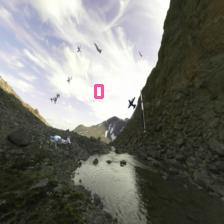
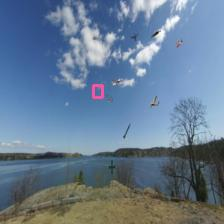
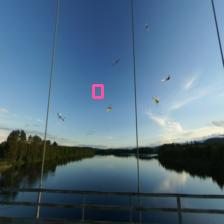
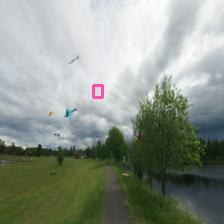

step: 687   lr: 0.00933   loss: 2.2271
step: 688   lr: 0.00933   loss: 1.9298
step: 689   lr: 0.00933   loss: 2.2254
step: 690   lr: 0.00932   loss: 2.0868
step: 691   lr: 0.00932   loss: 2.3529
step: 692   lr: 0.00932   loss: 2.0652
step: 693   lr: 0.00931   loss: 2.3251
step: 694   lr: 0.00931   loss: 1.9902
step: 695   lr: 0.00931   loss: 2.2391
step: 696   lr: 0.00930   loss: 2.4925
step: 697   lr: 0.00930   loss: 2.3868
step: 698   lr: 0.00930   loss: 2.2323
step: 699   lr: 0.00929   loss: 2.0179
step: 700   lr: 0.00929   loss: 1.8533
step: 701   lr: 0.00929   loss: 2.1517
step: 702   lr: 0.00928   loss: 2.0247
step: 703   lr: 0.00928   loss: 2.2604
step: 704   lr: 0.00928   loss: 2.3308
step: 705   lr: 0.00927   loss: 1.9237
step: 706   lr: 0.00927   loss: 2.0591
step: 707   lr: 0.00927   loss: 2.0880
step: 708   lr: 0.00926   loss: 2.1143
step: 709   lr: 0.00926   loss: 2.0792
step: 710   lr: 0.00926   loss: 2.2887
step: 711   lr: 0.00925   loss: 2.2399
step: 712   lr: 0.00925  


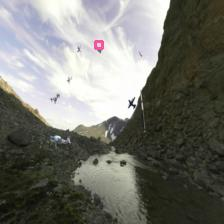
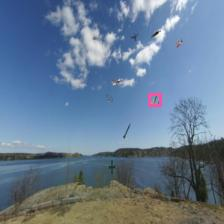
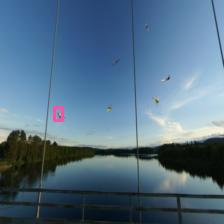
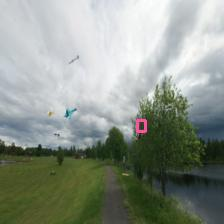

step: 1030   lr: 0.00788   loss: 1.8223
step: 1031   lr: 0.00787   loss: 1.6946
step: 1032   lr: 0.00787   loss: 1.4113
step: 1033   lr: 0.00786   loss: 1.6490
step: 1034   lr: 0.00786   loss: 1.7528
step: 1035   lr: 0.00785   loss: 1.6794
step: 1036   lr: 0.00784   loss: 1.7939
step: 1037   lr: 0.00784   loss: 1.9432
step: 1038   lr: 0.00783   loss: 1.4539
step: 1039   lr: 0.00783   loss: 1.5971
step: 1040   lr: 0.00782   loss: 1.5793
step: 1041   lr: 0.00782   loss: 1.4750
step: 1042   lr: 0.00781   loss: 1.6584
step: 1043   lr: 0.00781   loss: 1.5536
step: 1044   lr: 0.00780   loss: 1.6264
step: 1045   lr: 0.00780   loss: 1.9665
step: 1046   lr: 0.00779   loss: 1.8713
step: 1047   lr: 0.00779   loss: 1.7307
step: 1048   lr: 0.00778   loss: 1.7553
step: 1049   lr: 0.00778   loss: 1.4727
step: 1050   lr: 0.00777   loss: 1.4757
step: 1051   lr: 0.00777   loss: 1.5100
step: 1052   lr: 0.00776   loss: 1.6323
step: 1053   lr: 0.00776   loss: 1.7710
step: 1054   lr: 0.00775   loss: 1.4846



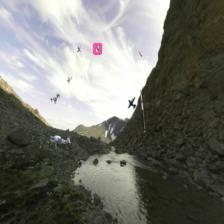
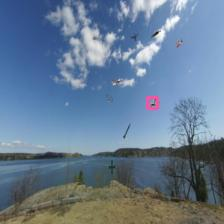
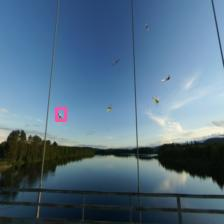
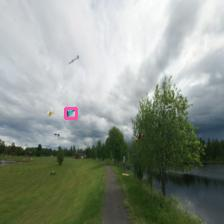

step: 1373   lr: 0.00588   loss: 1.4699
step: 1374   lr: 0.00588   loss: 1.5663
step: 1375   lr: 0.00587   loss: 1.5407
step: 1376   lr: 0.00586   loss: 1.3435
step: 1377   lr: 0.00586   loss: 1.4408
step: 1378   lr: 0.00585   loss: 1.3001
step: 1379   lr: 0.00585   loss: 1.6216
step: 1380   lr: 0.00584   loss: 1.2591
step: 1381   lr: 0.00583   loss: 1.3367
step: 1382   lr: 0.00583   loss: 1.5488
step: 1383   lr: 0.00582   loss: 1.4666
step: 1384   lr: 0.00581   loss: 1.4307
step: 1385   lr: 0.00581   loss: 1.6747
step: 1386   lr: 0.00580   loss: 1.3337
step: 1387   lr: 0.00580   loss: 1.4958
step: 1388   lr: 0.00579   loss: 1.1681
step: 1389   lr: 0.00578   loss: 1.3973
step: 1390   lr: 0.00578   loss: 1.5379
step: 1391   lr: 0.00577   loss: 1.3607
step: 1392   lr: 0.00576   loss: 1.4004
step: 1393   lr: 0.00576   loss: 1.8134
step: 1394   lr: 0.00575   loss: 1.4064
step: 1395   lr: 0.00575   loss: 1.1986
step: 1396   lr: 0.00574   loss: 1.3831
step: 1397   lr: 0.00573   loss: 1.5879



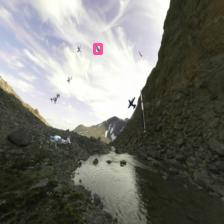
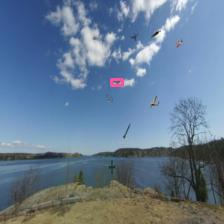
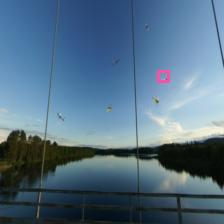
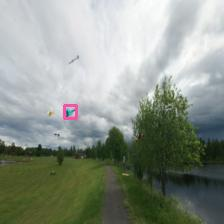

step: 1716   lr: 0.00373   loss: 1.3209
step: 1717   lr: 0.00372   loss: 1.2821
step: 1718   lr: 0.00371   loss: 1.6392
step: 1719   lr: 0.00371   loss: 1.2274
step: 1720   lr: 0.00370   loss: 1.1323
step: 1721   lr: 0.00370   loss: 1.1658
step: 1722   lr: 0.00369   loss: 1.2959
step: 1723   lr: 0.00368   loss: 1.1704
step: 1724   lr: 0.00368   loss: 1.3234
step: 1725   lr: 0.00367   loss: 1.2405
step: 1726   lr: 0.00367   loss: 1.2163
step: 1727   lr: 0.00366   loss: 1.3119
step: 1728   lr: 0.00365   loss: 1.2524
step: 1729   lr: 0.00365   loss: 1.1642
step: 1730   lr: 0.00364   loss: 0.9792
step: 1731   lr: 0.00363   loss: 1.3611
step: 1732   lr: 0.00363   loss: 1.4834
step: 1733   lr: 0.00362   loss: 1.7209
step: 1734   lr: 0.00362   loss: 1.3285
step: 1735   lr: 0.00361   loss: 1.1857
step: 1736   lr: 0.00360   loss: 1.4116
step: 1737   lr: 0.00360   loss: 1.1822
step: 1738   lr: 0.00359   loss: 1.3470
step: 1739   lr: 0.00359   loss: 1.2902
step: 1740   lr: 0.00358   loss: 1.2531



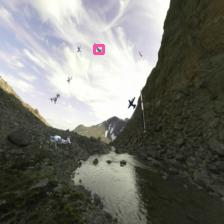
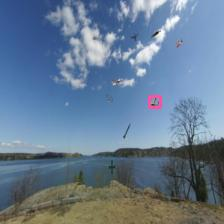
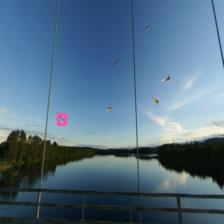
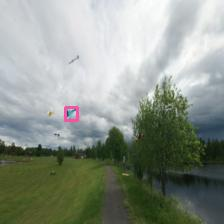

step: 2059   lr: 0.00181   loss: 1.2424
step: 2060   lr: 0.00180   loss: 1.1299
step: 2061   lr: 0.00180   loss: 1.1211
step: 2062   lr: 0.00179   loss: 1.2454
step: 2063   lr: 0.00179   loss: 1.1307
step: 2064   lr: 0.00178   loss: 1.2737
step: 2065   lr: 0.00178   loss: 1.1013
step: 2066   lr: 0.00177   loss: 1.1831
step: 2067   lr: 0.00177   loss: 1.1352
step: 2068   lr: 0.00176   loss: 0.9607
step: 2069   lr: 0.00176   loss: 1.0737
step: 2070   lr: 0.00175   loss: 0.9884
step: 2071   lr: 0.00175   loss: 1.3083
step: 2072   lr: 0.00174   loss: 1.0610
step: 2073   lr: 0.00174   loss: 1.1314
step: 2074   lr: 0.00173   loss: 1.2805
step: 2075   lr: 0.00173   loss: 1.1187
step: 2076   lr: 0.00172   loss: 1.1341
step: 2077   lr: 0.00172   loss: 1.0092
step: 2078   lr: 0.00171   loss: 1.1816
step: 2079   lr: 0.00171   loss: 1.2143
step: 2080   lr: 0.00171   loss: 1.2088
step: 2081   lr: 0.00170   loss: 1.1615
step: 2082   lr: 0.00170   loss: 0.9984
step: 2083   lr: 0.00169   loss: 1.0457


In [ ]:
# Training with epoches
import time

start_time = time.time()

BATCH_SIZE = 8
LEARNING_RATE = 0.01
NUM_EPOCHS = 1
TRAIN_EXAMPLES = 22000

TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
EVAL_STEPS = TRAIN_STEPS // 8

train_data_it = train_data_iterator()
  # Number of training examples

sched_fn = big_vision.utils.create_learning_rate_schedule(
    total_steps=TRAIN_STEPS * NUM_EPOCHS + 1,  # Adjust total steps for multiple epochs
    base=LEARNING_RATE,
    decay_type="cosine",
    warmup_percent=0.10)
try:
    # Run the training loop for multiple epochs
    for epoch in range(NUM_EPOCHS):
        print(f"Starting epoch {epoch + 1}/{NUM_EPOCHS}")

        for step in range(1, TRAIN_STEPS + 1):
            # Make list of N training examples.
            examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

            # Convert list of examples into a dict of np.arrays and load onto devices.
            batch = jax.tree.map(lambda *x: np.stack(x), *examples)
            batch = big_vision.utils.reshard(batch, data_sharding)

            # Compute the global step across all epochs
            global_step = epoch * TRAIN_STEPS + step

            # Training step and report training loss
            learning_rate = sched_fn(global_step)
            params, loss = update_fn(params, batch, learning_rate)
            loss = jax.device_get(loss)
            print(f"step: {global_step}   lr: {learning_rate:.5f}   loss: {loss:.4f}")

            if step == 1 or (step % EVAL_STEPS) == 0 or step == TRAIN_STEPS:
                print(f"Model predictions at step {global_step}")
                html_out = ""
                for example, result in make_predictions(validation_data_iterator(), num_examples=4, batch_size=4):
                    response = postprocess_tokens(example["text"])  # detokenize model input.
                    classes = response.replace('detect ', '')
                    label = split_and_keep_second_part(response)
                    html_out += render_example(example["image"], result, classes)
                display(HTML(html_out))


except Exception as e:
    print(f"An error occurred: {e}")
finally:
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    
    folder = "til-24-base/vlm/src/model"

    if not os.path.exists(folder):
        os.makedirs(folder)

    model_saved_path = "models/vlm/fine-tuned-22may-v3-test-paligemma-3b-pt-224.f16.npz"

    flat, _ = big_vision.utils.tree_flatten_with_names(params)
    with open(model_saved_path, "wb") as f:
        np.savez(f, **{k: v for k, v in flat})



In [ ]:

folder = "til-24-base/vlm/src/model"

if not os.path.exists(folder):
    os.makedirs(folder)

model_saved_path = "models/vlm/fine-tuned-22may-v3-test-paligemma-3b-pt-224.f16.npz"

flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(model_saved_path, "wb") as f:
    np.savez(f, **{k: v for k, v in flat})


In [80]:
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs
        

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = big_vision.utils.reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode({"params": params}, batch=batch,
                        max_decode_len=seqlen, sampler=sampler)
        # print(f"Token1 is {tokens}")

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        # print(f"Token2 is {tokens}")
        # print(f"Mask is {mask}")
        tokens = tokens[mask]  # remove padding examples.
        # print(f"Token3 is {tokens}")
        responses = [postprocess_tokens(t) for t in tokens]
        print(f"Responses: {responses}")

        # Append to html output.
        for example, response in zip(examples, responses):
            outputs.append((example, response))
            if num_examples and len(outputs) >= num_examples:
                print(f"Outputs: {outputs}")
                return outputs

In [ ]:
# @title Evaluate the model on all examples.
#
# The validation data consists of 10 images in a different domain than training
# data.

print("Model predictions")
html_out = ""
for example, caption in make_predictions(validation_data_iterator(), num_examples=4, batch_size=1):
    captionhoho = postprocess_tokens(example["text"])  # detokenize model input.
    classess = caption.replace('detect ', '')
    captionhoho = split_and_keep_second_part(captionhoho)
    print(f"caption2: {caption}")
    print(f"captionhoho: {captionhoho}")
    print(f"Classesss: {classess}")
    html_out += render_example(example["image"], caption, classess)
display(HTML(html_out))


In [18]:
folder = "til-24-base/vlm/src/model"

if not os.path.exists(folder):
    os.makedirs(folder)

model_saved_path = f"{folder}/fine-tuned-v2-test-paligemma-3b-pt-224.f16.npz"

flat, _ = big_vision.utils.tree_flatten_with_names(params)
with open(model_saved_path, "wb") as f:
    np.savez(f, **{k: v for k, v in flat})

In [86]:
def make_predictions_2(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    labels = [postprocess_tokens(e["label"]) for e in examples]
    responses = [postprocess_tokens(t) for t in tokens]
    print(f"Responses: {responses}")

    # Append to html output.
    for example, label, response in zip(examples, labels, responses):
      outputs.append((example["image"], label, response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

In [39]:
# @title Define preprocess functions to create inputs to the model.

def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
  # Model has been trained to handle tokenized text composed of a prefix with
  # full attention and a suffix with causal attention.
  separator = "\n"
  tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
  mask_ar = [0] * len(tokens)    # 0 to use full attention for prefix.
  mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

  if suffix:
    suffix = tokenizer.encode(suffix, add_eos=True)
    tokens += suffix
    mask_ar += [1] * len(suffix)    # 1 to use causal attention for suffix.
    mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

  mask_input = [1] * len(tokens)    # 1 if its a token, 0 if padding.
  if seqlen:
    padding = [0] * max(0, seqlen - len(tokens))
    tokens = tokens[:seqlen] + padding
    mask_ar = mask_ar[:seqlen] + padding
    mask_loss = mask_loss[:seqlen] + padding
    mask_input = mask_input[:seqlen] + padding

  return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


In [90]:

def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    image_path = example['image'].decode("utf-8")
    image = Image.open(image_path)
    print(f"Image path: {image_path}")
    # image = Image.open(io.BytesIO(example["image"]))
    image = preprocess_image(image)

    prefix = example["prefix"].decode().lower()
    suffix = example["suffix"].decode().lower()
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
    label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "label": np.asarray(label),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


Model predictions
(224, 224)
<re.Match object; span=(0, 65), match='<loc0202><loc0437><loc0242><loc0466> grey and whi>
[[96, 44, 102, 53]]
Detections: Detections(xyxy=array([[ 96,  44, 102,  53]]), mask=None, confidence=None, class_id=array([37]), tracker_id=None, data={'class_name': array(['grey and white fighter plane'], dtype='<U28')})



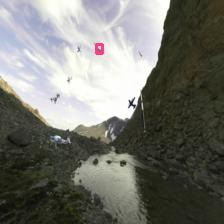

In [49]:
print("Model predictions")
html_out = ""
for image, label, caption in make_predictions_2(validation_data_iterator(), num_examples=1, batch_size=1):
    
  html_out += render_example(image, caption, label)
display(HTML(html_out))

In [78]:
test = "<loc0616><loc0223><loc0677><loc0326> grey and white fighter plane"

def get_label(label):
    label = label.split(">")[-1].strip()
    return label

get_label(test)
    

'grey and white fighter plane'

In [91]:
# @title Collect predictions
targets = []
predictions = []

for image, label, prediction in make_predictions_2(validation_data_iterator(), num_examples=1, batch_size=1):
    h, w, _ = image.shape
    target = from_pali_gemma(label, (w, h), get_label(label))

    targets.append(target)
    prediction = from_pali_gemma(prediction, (w, h), get_label(prediction))

    prediction.confidence = np.ones(len(prediction))
    predictions.append(prediction)

Image path: advanced/images/image_790.jpg
Responses: ['<loc0202><loc0437><loc0242><loc0466> grey and white fighter plane']
(224, 224)
<re.Match object; span=(0, 66), match='<loc0616><loc0223><loc0677><loc0326> grey and whi>
[[49, 135, 71, 148]]
(224, 224)
<re.Match object; span=(0, 65), match='<loc0202><loc0437><loc0242><loc0466> grey and whi>
[[96, 44, 102, 53]]


In [88]:
print(targets)
print()
print(predictions)

[Detections(xyxy=array([[ 49, 135,  71, 148]]), mask=None, confidence=None, class_id=array([0]), tracker_id=None, data={'class_name': array(['grey and white fighter plane'], dtype='<U28')})]

[Detections(xyxy=array([[ 96,  44, 102,  53]]), mask=None, confidence=array([1.]), class_id=array([0]), tracker_id=None, data={'class_name': array(['grey and white fighter plane'], dtype='<U28')})]


(1520, 870)


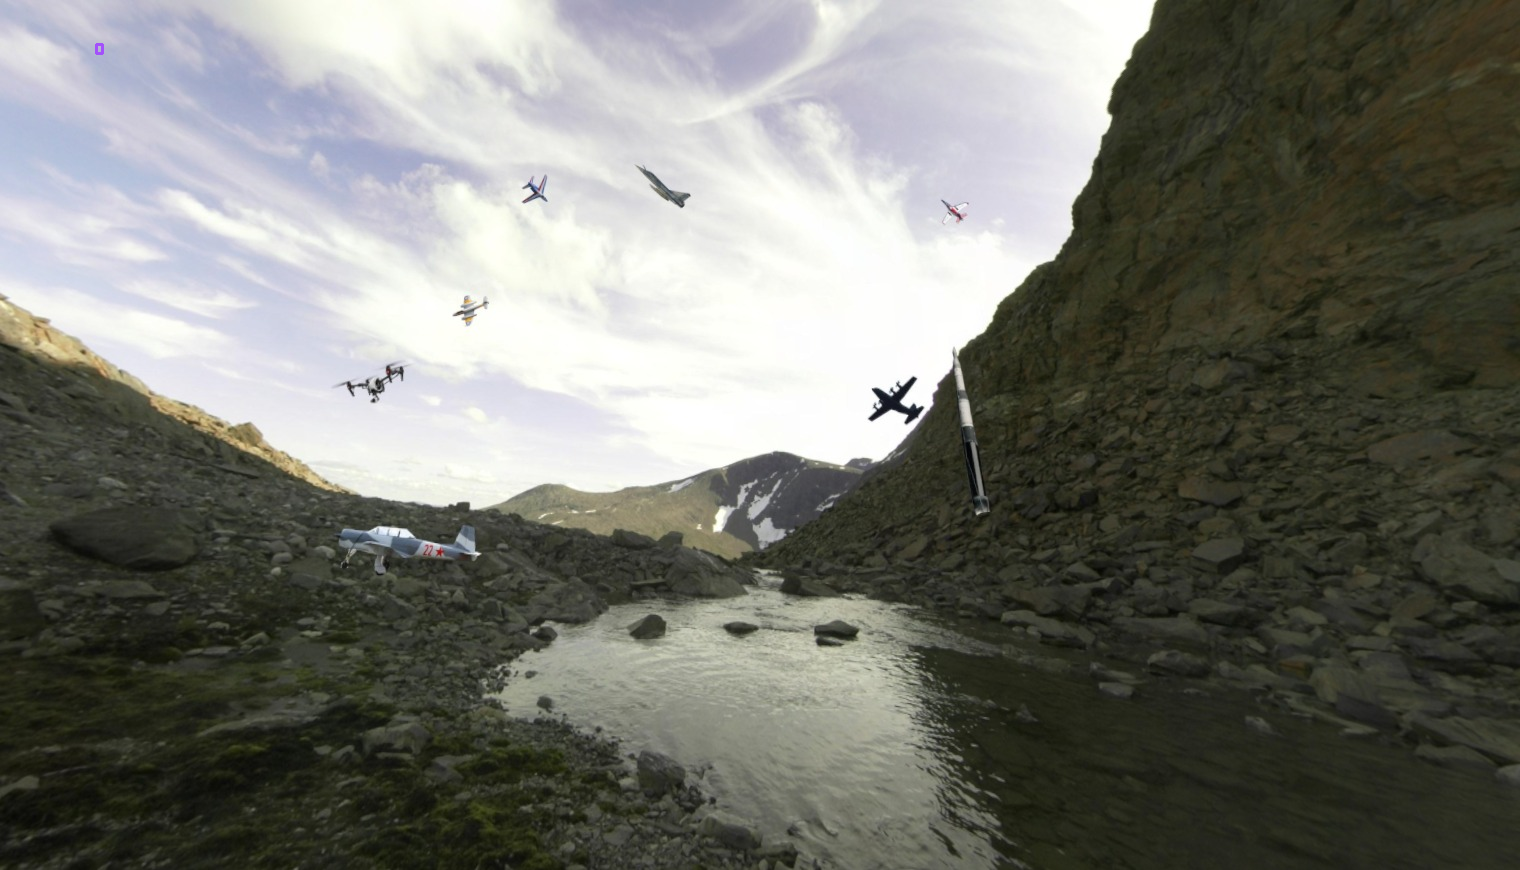

In [93]:
from PIL import Image
import json

index = 10

image_path = "advanced/images/image_790.jpg"

image = Image.open(image_path)
print(image.size)

sv.BoundingBoxAnnotator().annotate(image, predictions[0])

In [89]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.00
map50: 0.00
map75: 0.00


In [53]:
predictions[0]

IndexError: list index out of range

In [35]:
!pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /var/tmp/pip-req-build-m72tny0l
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /var/tmp/pip-req-build-m72tny0l
  Resolved https://github.com/huggingface/transformers to commit 0df888ffb72ea370555efdef45985378d3cc7b2b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.2 MB/s eta 0:00:0000:0100:01
  Created wheel for transformers: filename=transformers-4.42.0.dev0-py3-none-any.whl size=9105423 sha256=f8c6b110fe56281ac00a1be3c75a0a44d8485a2a749c2a7bb0ad7b572c8cc92f
  Stored in directory: /var/tmp/pip-ephem-wheel-cache-recr36hg/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizer